In [6]:
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.datasets import make_swiss_roll


class SwissRoll_Dataset(Dataset):
    def __init__(self, data_size = 10000, phase='test', use_2D_otherwise_3D = True):
        super(SwissRoll_Dataset, self).__init__()
        self.use_2D_otherwise_3D = use_2D_otherwise_3D

        data, _ = make_swiss_roll(n_samples=data_size, noise=0.3)

        if use_2D_otherwise_3D:
            # If 2D, select only the first and third columns (x and z axes).
            data = data[:, [0, 2]]/10
            data_dim = 2
        else:
            # If 3D, use all three columns.
            data_dim = 3

        # Initialize the dataset with zeros
        self.inputs = data.reshape(data_size, data_dim)

        self.size = int(90.0 / 100.0 * len(self.inputs))

        if phase == 'train':
            self.data = self.inputs[:self.size]
        elif phase == 'test':
            self.data = self.inputs[self.size:]
    
    
    def __len__(self):
        return len(self.data)

    def __iter__(self):
        return self

    def __getitem__(self, index):
        
        return self.data[index]

# Visualisation for original diffusion default setting with VP: "beta_min": 0.1, "beta_max": 20 and step=100

In [3]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
import torch

device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev
    
    def backward_k_step(self, x_t, t, step, net, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        for i in range(step):
            z = torch.randn_like(x_t).to(device)
            pred_score = net(x_t, t)
            f_t, g_t = self.sde.drifts(x_t, t)
            f_t = f_t.to(device)
            x_t = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
            t = t - 1
            if clip_denoised and x_t.ndim > 2:
                print('backward_one_step')
                x_t.clamp_(-1., 1.)

        return x_t

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.stack(trajs,1)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1,data.shape[1]])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score) #.detach()
            trajs.append(x_t)
        # print(x_t.shape, torch.hstack(trajs).shape)
        return x_t, torch.hstack(trajs)
    
    def q_step_backward_sample(self, noise, net, step, end_t):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(end_t-step+1, end_t)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score) #.detach()
            # print(x_t.shape)
            trajs.append(x_t)

        return x_t, torch.stack(trajs,1)
    

    def backward_sample_example(self, forward_process, net, skip_step=1):
        """
        Sample from backward diffusion process
        forward_process: torch.tensor, shape=[num_paths, T]
        """
        forward_end = forward_process[:, -1]
        backward_trajs = []
        forward_trajs = []
        backward_trajs.append(forward_end.unsqueeze(1))
        forward_trajs.append(forward_end.unsqueeze(1))
        for t in range(self.total_steps, skip_step-1, -skip_step):
            x_t = self.backward_k_step(forward_process[:,t].unsqueeze(1), t, skip_step, net)
            backward_trajs.append(x_t)
            forward_trajs.append(forward_process[:,t-skip_step].unsqueeze(1))
        left_steps = t - skip_step
        while left_steps > 0:
            pred_score = net(forward_process[:,left_steps].unsqueeze(1), left_steps)
            x_t = self.backward_one_step(x_t, left_steps, pred_score)
            backward_trajs.append(x_t)
            forward_trajs.append(forward_process[:,left_steps-1].unsqueeze(1)) 
            left_steps -= 1
        forward_trajs = torch.stack(forward_trajs, dim=1)
        backward_trajs = torch.stack(backward_trajs,dim=1)
        return x_t, forward_trajs, backward_trajs 


  0%|          | 0/35 [00:00<?, ?it/s]


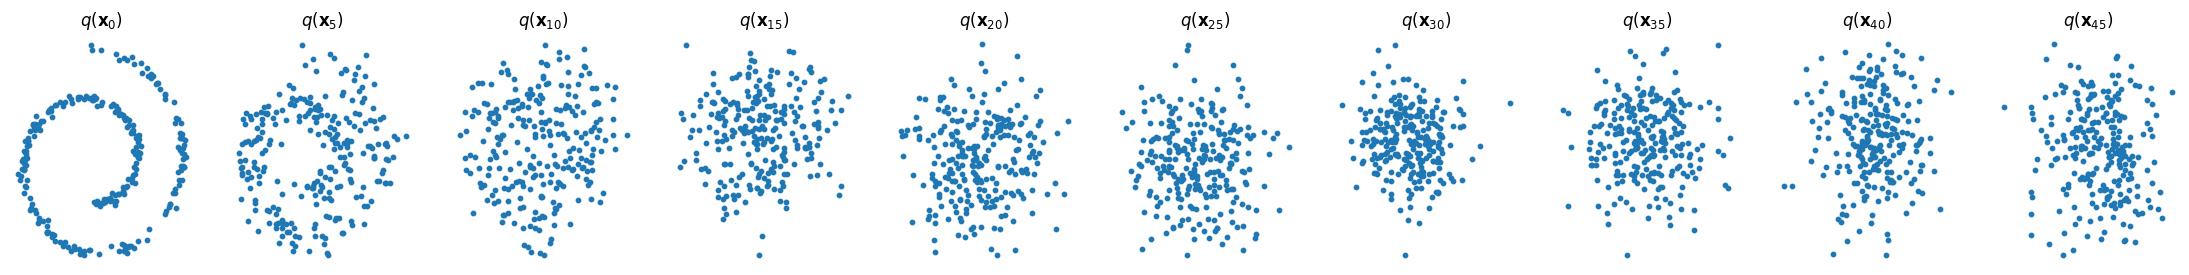

In [9]:
total_steps = 100
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

train_batch_size = 256
num_worker = 8

train_data_loader = torch.utils.data.DataLoader(
            dataset=SwissRoll_Dataset(data_size = 10000, phase='train', use_2D_otherwise_3D = True),
            batch_size = train_batch_size,
            shuffle=True,
            num_workers= num_worker,
            drop_last=True,
            worker_init_fn=init_seed)

for forward_bacth in tqdm(train_data_loader, dynamic_ncols=True):
    fig, axs = plt.subplots(1, 10, figsize=(28, 3))
    x_noise, traj_forward = diffusion.forward_sample(forward_bacth)
    for i in range(10):        
        axs[i].scatter(traj_forward[:,i*5, 0], traj_forward[:,i*5, 1], s=10)
        axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*5)+'})$')

    break


# Improved diffusion params setting with VP: "beta_min": 0.01, "beta_max": 2 and step=100

In [ ]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
import torch

device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.01, "beta_max": 2},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev
    
    def backward_k_step(self, x_t, t, step, net, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        for i in range(step):
            z = torch.randn_like(x_t).to(device)
            pred_score = net(x_t, t)
            f_t, g_t = self.sde.drifts(x_t, t)
            f_t = f_t.to(device)
            x_t = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
            t = t - 1
            if clip_denoised and x_t.ndim > 2:
                print('backward_one_step')
                x_t.clamp_(-1., 1.)

        return x_t

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.stack(trajs,1)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1,data.shape[1]])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score) #.detach()
            trajs.append(x_t)
        # print(x_t.shape, torch.hstack(trajs).shape)
        return x_t, torch.hstack(trajs)
    
    def q_step_backward_sample(self, noise, net, step, end_t):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(end_t-step+1, end_t)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score) #.detach()
            # print(x_t.shape)
            trajs.append(x_t)

        return x_t, torch.stack(trajs,1)
    

    def backward_sample_example(self, forward_process, net, skip_step=1):
        """
        Sample from backward diffusion process
        forward_process: torch.tensor, shape=[num_paths, T]
        """
        forward_end = forward_process[:, -1]
        backward_trajs = []
        forward_trajs = []
        backward_trajs.append(forward_end.unsqueeze(1))
        forward_trajs.append(forward_end.unsqueeze(1))
        for t in range(self.total_steps, skip_step-1, -skip_step):
            x_t = self.backward_k_step(forward_process[:,t].unsqueeze(1), t, skip_step, net)
            backward_trajs.append(x_t)
            forward_trajs.append(forward_process[:,t-skip_step].unsqueeze(1))
        left_steps = t - skip_step
        while left_steps > 0:
            pred_score = net(forward_process[:,left_steps].unsqueeze(1), left_steps)
            x_t = self.backward_one_step(x_t, left_steps, pred_score)
            backward_trajs.append(x_t)
            forward_trajs.append(forward_process[:,left_steps-1].unsqueeze(1)) 
            left_steps -= 1
        forward_trajs = torch.stack(forward_trajs, dim=1)
        backward_trajs = torch.stack(backward_trajs,dim=1)
        return x_t, forward_trajs, backward_trajs 

            



In [37]:
total_steps = 100
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

In [38]:
score_net = ToyNet(data_dim=2).to(device)

pcf = PCF_with_empirical_measure(16, 10, 2, add_time=True).to(device)

G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-4)

In [39]:
import torch.nn.functional as F
def loss_function(x0, diffusion_process, score_net, t):
    #f_t is not involved in the score matching loss soe input zeros for the 1st argument.
    #
    _, g_t = diffusion_process.sde.drifts(torch.zeros_like(x0), t)
    
    # Eq 29 in Score based diffusion model (Yang Song 2021 ICLR)
    mean, std = diffusion_process.sde.perturbation_kernel(x0, t)
    z = torch.randn_like(x0)

    x_t = mean + std * z  # x_t is perturbed x_0
    pred_score = score_net(x_t, t)
    target = -z / std   # Since desired derivative of the given kernel is - (x_t - mean) / std^2
    loss = g_t**2 * F.mse_loss(pred_score, target, reduction="sum") / np.prod(x0.size())
    return loss

In [40]:
train_batch_size = 256
num_worker = 8

train_data_loader = torch.utils.data.DataLoader(
            dataset=SwissRoll_Dataset(data_size = 10000, phase='train', use_2D_otherwise_3D = True),
            batch_size = train_batch_size,
            shuffle=True,
            num_workers= num_worker,
            drop_last=True,
            worker_init_fn=init_seed)


  0%|          | 0/35 [00:00<?, ?it/s]


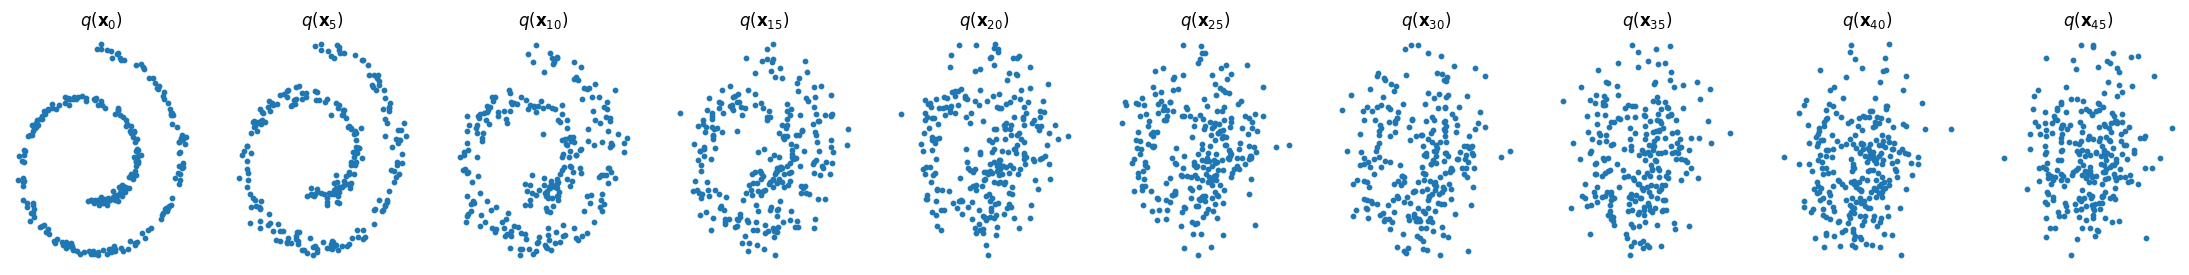

In [43]:
for forward_bacth in tqdm(train_data_loader, dynamic_ncols=True):
    fig, axs = plt.subplots(1, 10, figsize=(28, 3))
    x_noise, traj_forward = diffusion.forward_sample(forward_bacth)
    for i in range(10):        
        axs[i].scatter(traj_forward[:,i*5, 0], traj_forward[:,i*5, 1], s=10)
        axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*5)+'})$')

    break


0 3.5836596488952637


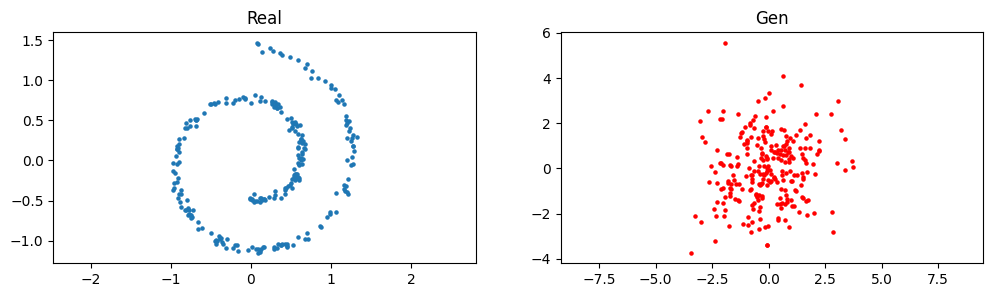

250 2.3675358295440674


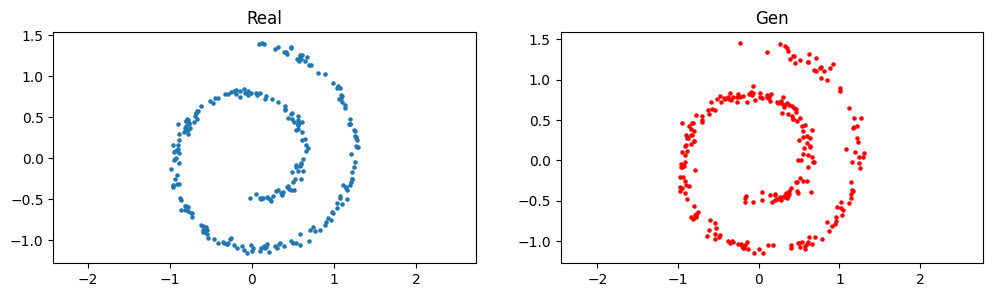

500 0.6986097693443298


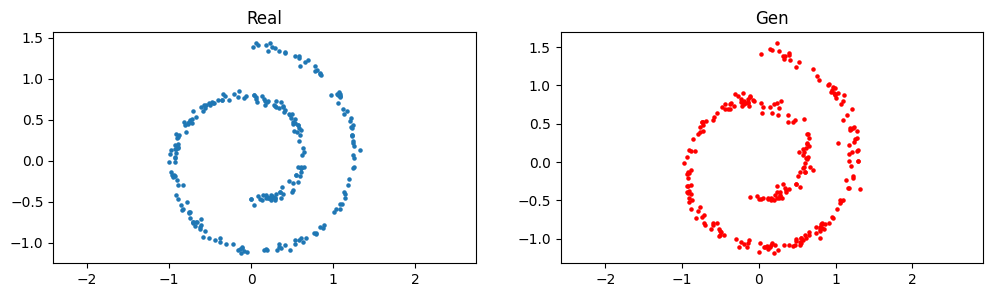

750 6.459694862365723


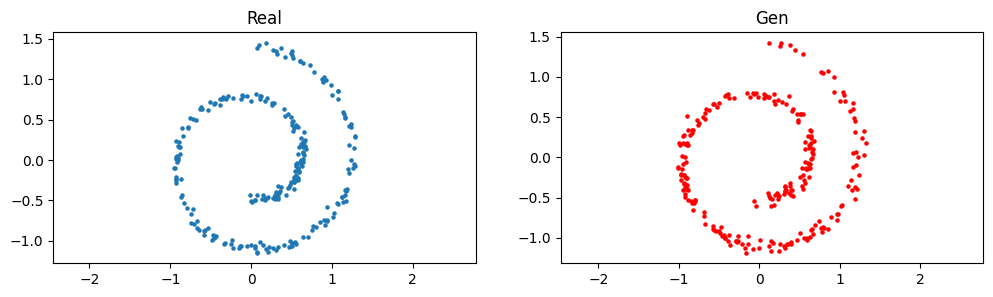

1000 2.706460475921631


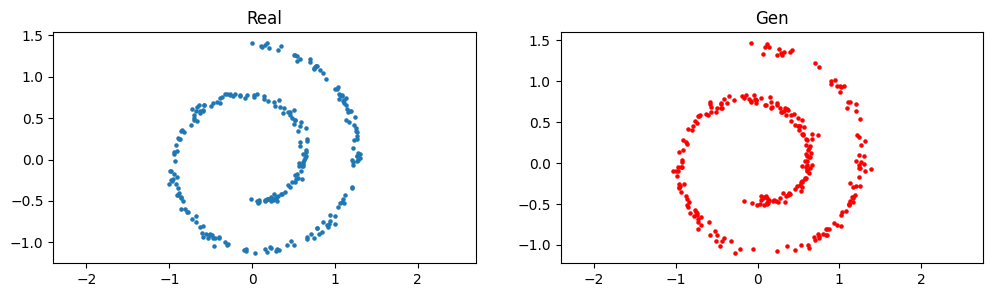

1250 0.9726645350456238


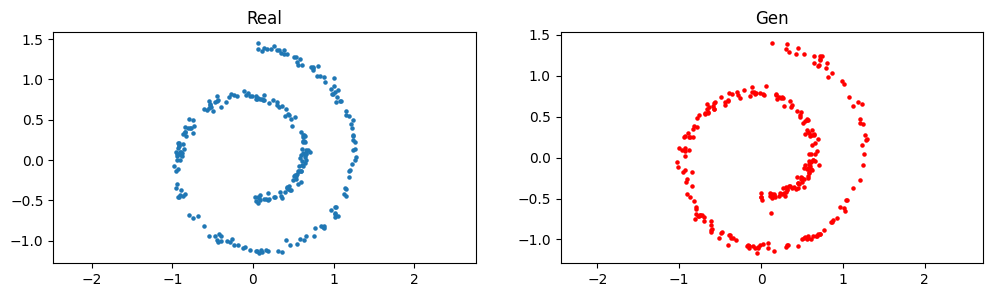

1500 1.5016863346099854


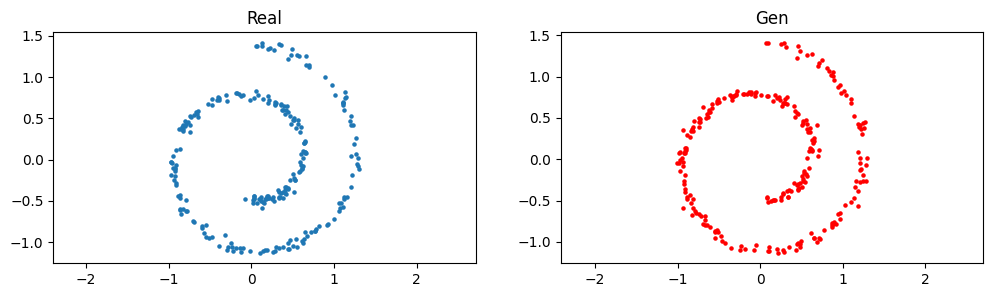

1750 4.829537391662598


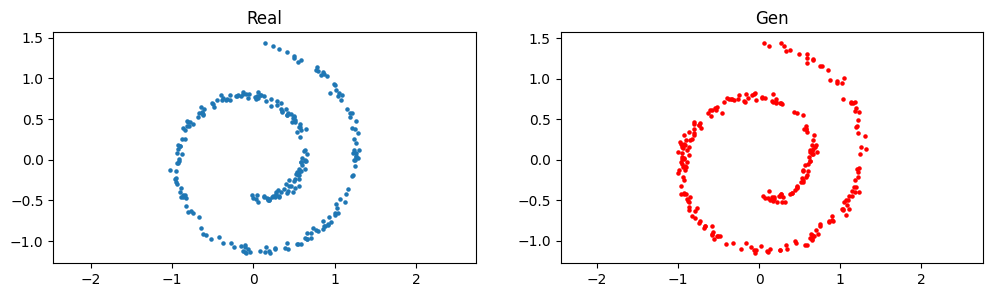

In [44]:
def plot_x_gen(x_real, x_gen):
    plt.figure(figsize=(12,3))
    plt.subplot(1, 2, 1)
    
    plt.scatter(x_real[:, 0], x_real[:, 1], s=5, alpha=1.0)
    #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
    plt.axis('equal')
    #plt.ylabel(f't={t}')
    plt.title('Real')
        
    plt.subplot(1, 2, 2)
    plt.scatter(x_gen[:, 0], x_gen[:, 1], s=5, alpha=1.0, color='r')
    #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
    plt.axis('equal')
    plt.title('Gen')
    plt.show()

num_epochs = 2000


for i in range(num_epochs):

    # x_data = data_dist.sample([num_paths]
    for forward_bacth in train_data_loader:
        t = np.random.randint(1, total_steps + 1)
        score_loss = loss_function(forward_bacth.view(-1 ,2).float().to(device), diffusion, score_net, t)

        G_loss = score_loss
        
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
    if i % 250 == 0:
        print(i, G_loss.item())
        x_gen, traj_back = diffusion.sample(torch.randn([train_batch_size, 2]).to(device), score_net)
        plot_x_gen(forward_bacth, x_gen.detach().cpu())
    

In [45]:
test_batch_size = 200

test_data_loader = torch.utils.data.DataLoader(
            dataset=SwissRoll_Dataset(data_size = 10000, phase='test', use_2D_otherwise_3D = True),
            batch_size = test_batch_size,
            shuffle=False,
            num_workers= num_worker,
            drop_last=False,
            worker_init_fn=init_seed)


  0%|          | 0/5 [00:00<?, ?it/s]

(200, 2)


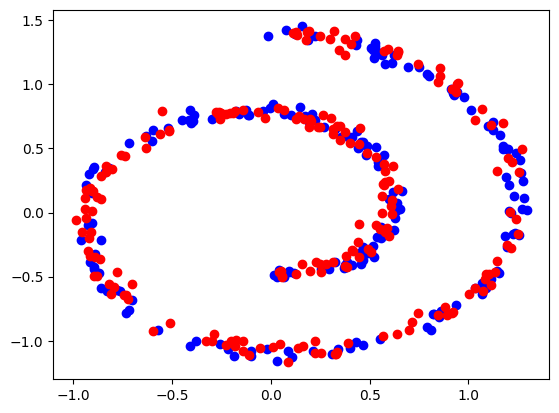

In [46]:
# x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
# xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure()
for test_example in tqdm(test_data_loader, dynamic_ncols=True):
    plt.scatter(
                test_example[:,  0],
                test_example[:,  1],
                c="b",
                label="Train Data",
            )
    x_noise, traj_forward = diffusion.forward_sample(test_example)
    noise = torch.randn(x_noise.shape).to(device)
    x_gen, traj_back = diffusion.sample(noise.float(), score_net)
    x_gen = x_gen.cpu().detach().numpy()
    print(x_gen.shape)
    plt.scatter(
                x_gen[:, 0],
                x_gen[:, 1],
                c="r",
                label="Generated Data",
            )
    break

In [47]:
torch.save(score_net.state_dict(), './score_net_score_swiss_epoch2000_lowerbeta.pt')
torch.save(pcf.state_dict(), './pcf_score_swiss_epoch2000_lowerbeta.pt')

  0%|          | 0/5 [00:00<?, ?it/s]


<Figure size 640x480 with 0 Axes>

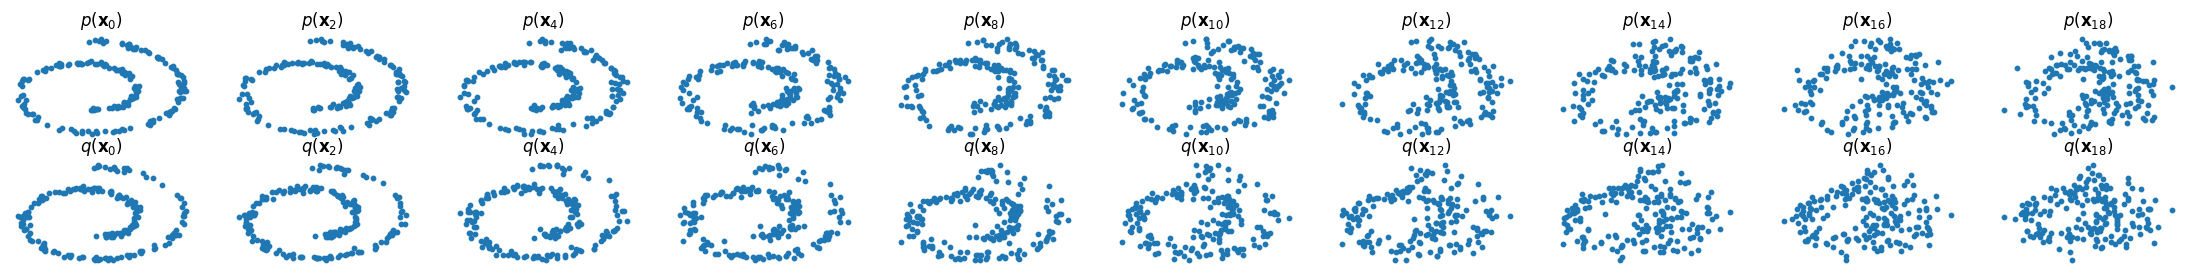

In [48]:
plt.figure()
for test_example in tqdm(test_data_loader, dynamic_ncols=True):
    fig, axs = plt.subplots(2, 10, figsize=(28, 3))
    x_noise, traj_forward = diffusion.forward_sample(test_example)
    for i in range(10):
        axs[0,i].scatter(traj_forward[:,i*2, 0], traj_forward[:,i*2, 1], s=10)
        axs[0,i].set_axis_off(); axs[0,i].set_title('$p(\mathbf{x}_{'+str(i*2)+'})$')
    noise = torch.randn(x_noise.shape).to(device)
    x_gen, traj_back = diffusion.sample(noise.float(), score_net)
    x_gen = x_gen.cpu().detach().numpy()    
    traj_back = torch.fliplr(traj_back).cpu().detach().numpy()

    for i in range(10):
        axs[1,i].scatter(traj_back[:,i*2, 0], traj_back[:,i*2, 1], s=10)
        axs[1,i].set_axis_off(); axs[1,i].set_title('$q(\mathbf{x}_{'+str(i*2)+'})$')
    
    break


# Evaluate the model's performance  

Compare the model performance in two situations.
Models: 

Model 1: diffusion loss+ q-step PCFD loss
Model 2: Train with score matching like other normal methods.

Two situations:
1. Compare the distribution of the forward process and bardward process.
2. Compare the distribution of the X_0 and Y_0. 

Metrics:
marginal distribution score
covariance score

In [2]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
import torch

device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.01, "beta_max": 2},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev
    
    def backward_k_step(self, x_t, t, step, net, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        for i in range(step):
            z = torch.randn_like(x_t).to(device)
            pred_score = net(x_t, t)
            f_t, g_t = self.sde.drifts(x_t, t)
            f_t = f_t.to(device)
            x_t = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
            t = t - 1
            if clip_denoised and x_t.ndim > 2:
                print('backward_one_step')
                x_t.clamp_(-1., 1.)

        return x_t

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.stack(trajs,1)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1,data.shape[1]])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score) #.detach()
            trajs.append(x_t)
        # print(x_t.shape, torch.hstack(trajs).shape)
        return x_t, torch.hstack(trajs)
    
    def q_step_backward_sample(self, noise, net, step, end_t):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(end_t-step+1, end_t)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score) #.detach()
            trajs.append(x_t)

        return x_t, torch.stack(trajs,1)
    

    def backward_sample_example(self, forward_process, net, skip_step=1):
        """
        Sample from backward diffusion process
        forward_process: torch.tensor, shape=[num_paths, T]
        """
        forward_end = forward_process[:, -1]
        backward_trajs = []
        forward_trajs = []
        backward_trajs.append(forward_end.unsqueeze(1))
        forward_trajs.append(forward_end.unsqueeze(1))
        for t in range(self.total_steps, skip_step-1, -skip_step):
            x_t = self.backward_k_step(forward_process[:,t].unsqueeze(1), t, skip_step, net)
            backward_trajs.append(x_t)
            forward_trajs.append(forward_process[:,t-skip_step].unsqueeze(1))
        left_steps = t - skip_step
        while left_steps > 0:
            pred_score = net(forward_process[:,left_steps].unsqueeze(1), left_steps)
            x_t = self.backward_one_step(x_t, left_steps, pred_score)
            backward_trajs.append(x_t)
            forward_trajs.append(forward_process[:,left_steps-1].unsqueeze(1)) 
            left_steps -= 1
        forward_trajs = torch.stack(forward_trajs, dim=1)
        backward_trajs = torch.stack(backward_trajs,dim=1)
        return x_t, forward_trajs, backward_trajs 

            



In [3]:
total_steps = 100
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")


In [4]:
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.datasets import make_swiss_roll


class SwissRoll_Dataset(Dataset):
    def __init__(self, data_size = 10000, phase='test', use_2D_otherwise_3D = True):
        super(SwissRoll_Dataset, self).__init__()
        self.use_2D_otherwise_3D = use_2D_otherwise_3D

        data, _ = make_swiss_roll(n_samples=data_size, noise=0.3)

        if use_2D_otherwise_3D:
            # If 2D, select only the first and third columns (x and z axes).
            data = data[:, [0, 2]]/10
            data_dim = 2
        else:
            # If 3D, use all three columns.
            data_dim = 3

        # Initialize the dataset with zeros
        self.inputs = data.reshape(data_size, data_dim)

        if phase == 'train':
            self.size = int(90.0 / 100.0 * len(self.inputs))
            self.data = self.inputs[:self.size]
        elif phase == 'test':
            self.size = 9000 #int(90.0 / 100.0 * len(self.inputs))
            self.data = self.inputs[self.size:]
    
    
    def __len__(self):
        return len(self.data)

    def __iter__(self):
        return self

    def __getitem__(self, index):
        
        return self.data[index]

In [5]:
test_batch_size = 200
num_worker = 8
test_data_loader = torch.utils.data.DataLoader(
            dataset=SwissRoll_Dataset(data_size = 20000, phase='test', use_2D_otherwise_3D = True),
            batch_size = test_batch_size,
            shuffle=False,
            num_workers= num_worker,
            drop_last=False,
            worker_init_fn=init_seed)


In [9]:
diffusion_score_model = ToyNet(data_dim=2).to(device)
diffusion_score_model.load_state_dict(torch.load('./score_net_5steps+score_swiss_lessbeta_3.pt'))
diffusion_score_model.eval()

# diffusion_score_model2 = ToyNet(data_dim=2).to(device)
# diffusion_score_model2.load_state_dict(torch.load('./score_net_5steps+score_swiss_lessbeta.pt'))
# diffusion_score_model2.eval()

diffusion_score_model3 = ToyNet(data_dim=2).to(device)
diffusion_score_model3.load_state_dict(torch.load('./score_net_score_swiss_epoch2000_lowerbeta.pt'))
diffusion_score_model3.eval()

/tmp/ipykernel_3466552/2503734644.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion_score_model.load_state_dict(torch.load('./score_net_5steps+score_swiss_lessbe

ToyNet(
  (t_module): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (x_module): ResNet_FC(
    (map): Linear(in_features=2, out_features=256, bias=True)
    (res_blocks): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): SiLU()
        (4): Linear(in_features=256, out_features=256, bias=True)
        (5): SiLU()
      )
    )
  )
  (out_module): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [10]:
from src.utils1 import loader_to_tensor
from src.evaluations.test_metrics import  HistoLoss
from src.evaluations.test_metrics import  CovLoss

def to_numpy(x):
    """
    Casts torch.Tensor to a numpy ndarray.

    The function detaches the tensor from its gradients, then puts it onto the cpu and at last casts it to numpy.
    """
    return x.detach().cpu().numpy()

# Sig_mmd1 = 0
# Sig_mmd2 = 0 
hist_losses1 = []
# hist_losses2 = []
hist_losses3 = []
hist_losses4 = []
hist_losses5 = []
hist_losses6 = []

cov_losses1 = []
# cov_losses2 = []
cov_losses3 = []
cov_losses4 = []
cov_losses5 = []
cov_losses6 = []


for forward_bacth in tqdm(test_data_loader, dynamic_ncols=True):
    x_noise, traj_forward = diffusion.forward_sample(forward_bacth)
    
    #revsered_traj_init = forward_end_point.unsqueeze(1).cuda()
    revsered_traj_init = torch.randn(x_noise.shape).to(device)
    x_gen, traj_back = diffusion.sample(revsered_traj_init.float(), diffusion_score_model)
    # x_gen2, traj_back2 = diffusion.sample(revsered_traj_init, diffusion_score_model2)
    x_gen2, traj_back3 = diffusion.sample(revsered_traj_init, diffusion_score_model3)
    # test_metrics_test = get_standard_test_metrics(x_real_test.unsqueeze(2))
    # Sig_mmd1 += test_metrics_test[0].compute(traj_back.unsqueeze(2))
    # Sig_mmd2 += test_metrics_test[0].compute(traj_back2.unsqueeze(2))
    hist_losses1.append(to_numpy(
        HistoLoss(traj_forward, n_bins=50, name='marginal_distribution')(torch.fliplr(traj_back))))
    cov_losses1.append(to_numpy(CovLoss(traj_forward, name='covariance')(torch.fliplr(traj_back))))

    # hist_losses2.append(to_numpy(
    #     HistoLoss(traj_forward, n_bins=50, name='marginal_distribution')(torch.fliplr(traj_back2))))
    # cov_losses2.append(to_numpy(CovLoss(traj_forward, name='covariance')(torch.fliplr(traj_back2))))
    
    hist_losses3.append(to_numpy(
        HistoLoss(traj_forward[:,0].unsqueeze(1), n_bins=50, name='marginal_distribution')(traj_back[:,-1].unsqueeze(1))))
    cov_losses3.append(to_numpy(CovLoss(traj_forward[:,0].unsqueeze(1), name='covariance')(traj_back[:,-1].unsqueeze(1))))

    # hist_losses4.append(to_numpy(
    #     HistoLoss(traj_forward[:,0].unsqueeze(1), n_bins=50, name='marginal_distribution')(traj_back2[:,-1].unsqueeze(1))))
    # cov_losses4.append(to_numpy(CovLoss(traj_forward[:,0].unsqueeze(1), name='covariance')(traj_back2[:,-1].unsqueeze(1))))

    hist_losses5.append(to_numpy(
        HistoLoss(traj_forward, n_bins=50, name='marginal_distribution')(torch.fliplr(traj_back3))))
    cov_losses5.append(to_numpy(CovLoss(traj_forward, name='covariance')(torch.fliplr(traj_back3))))

    hist_losses6.append(to_numpy(
        HistoLoss(traj_forward[:,0].unsqueeze(1), n_bins=50, name='marginal_distribution')(traj_back3[:,-1].unsqueeze(1))))
    cov_losses6.append(to_numpy(CovLoss(traj_forward[:,0].unsqueeze(1), name='covariance')(traj_back3[:,-1].unsqueeze(1))))

# print(Sig_mmd1.item())
# print(Sig_mmd2.item())
hist_mean1, hist_std1 = np.array(hist_losses1).mean(), np.array(hist_losses1).std()
# hist_mean2, hist_std2 = np.array(hist_losses2).mean(), np.array(hist_losses2).std()
hist_mean3, hist_std3 = np.array(hist_losses3).mean(), np.array(hist_losses3).std()
# hist_mean4, hist_std4 = np.array(hist_losses4).mean(), np.array(hist_losses4).std()
hist_mean5, hist_std5 = np.array(hist_losses5).mean(), np.array(hist_losses5).std()
hist_mean6, hist_std6 = np.array(hist_losses6).mean(), np.array(hist_losses6).std()


cov_mean1, cov_std1 = np.array(cov_losses1).mean(), np.array(cov_losses1).std()
# cov_mean2, cov_std2 = np.array(cov_losses2).mean(), np.array(cov_losses2).std()
cov_mean3, cov_std3 = np.array(cov_losses3).mean(), np.array(cov_losses3).std()
# cov_mean4, cov_std4 = np.array(cov_losses4).mean(), np.array(cov_losses4).std()
cov_mean5, cov_std5 = np.array(cov_losses5).mean(), np.array(cov_losses5).std()
cov_mean6, cov_std6 = np.array(cov_losses6).mean(), np.array(cov_losses6).std()

print('marginal_distribution loss of the whole process with score matching loss+ q-step PCF loss with mean:', hist_mean1, 'std:', hist_std1)
# print('marginal_distribution loss of the whole process with score matching (5000 epochs) with mean:', hist_mean2, 'std:', hist_std2)
print('marginal_distribution loss of the whole process with score matching (2000 epochs) with mean:', hist_mean5, 'std:', hist_std5)
print('')

print('marginal_distribution loss with with score matching loss+ q-step PCF loss at the last time point with mean:', hist_mean3, 'std:', hist_std3)
# print('marginal_distribution loss with score matching (5000 epochs) at the last time point with mean:', hist_mean4, 'std:', hist_std4)
print('marginal_distribution loss with score matching (2000 epochs) at the last time point with mean:', hist_mean6, 'std:', hist_std6)
print('')

print('variance loss of the whole process with score matching loss+ q-step PCF loss with mean:', cov_mean1, 'std:', cov_std1)
# print('variance loss of the whole process with score matching (5000 epochs) with mean:', cov_mean2, 'std:', cov_std2)
print('variance loss of the whole process with score matching (2000 epochs) with mean:', cov_mean5, 'std:', cov_std5)
print('')

print('variance loss at the last time point with score matching loss+ q-step PCF loss with mean:', cov_mean3, 'std:', cov_std3)
# print('variance loss at the last time point with score matching (5000 epochs) with mean :', cov_mean4, 'std:', cov_std4)
print('variance loss at the last time point with score matching (2000 epochs) with mean:', cov_mean6, 'std:', cov_std6)



  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [00:18<00:00,  3.00it/s]

marginal_distribution loss of the whole process with score matching loss+ q-step PCF loss with mean: 0.14678234 std: 0.004733547
marginal_distribution loss of the whole process with score matching (2000 epochs) with mean: 0.14681233 std: 0.005100462

marginal_distribution loss with with score matching loss+ q-step PCF loss at the last time point with mean: 0.22256324 std: 0.016449235
marginal_distribution loss with score matching (2000 epochs) at the last time point with mean: 0.22492363 std: 0.017990671

variance loss of the whole process with score matching loss+ q-step PCF loss with mean: 0.056895733 std: 0.014760292
variance loss of the whole process with score matching (2000 epochs) with mean: 0.061834835 std: 0.019705582

variance loss at the last time point with score matching loss+ q-step PCF loss with mean: 0.034398526 std: 0.019575734
variance loss at the last time point with score matching (2000 epochs) with mean: 0.033209022 std: 0.016918607


  0%|          | 0/55 [00:00<?, ?it/s]


<Figure size 640x480 with 0 Axes>

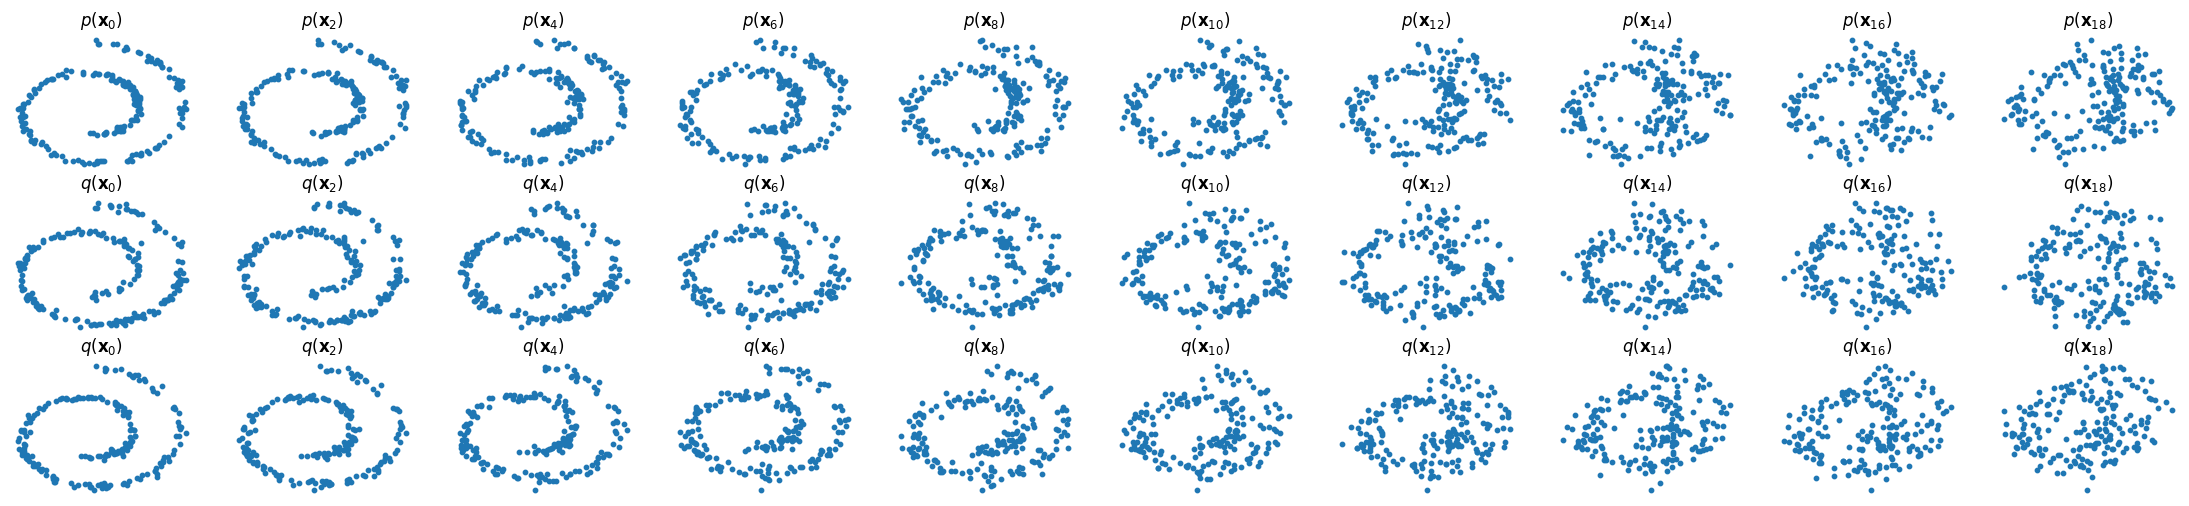

In [14]:
plt.figure()
for test_example in tqdm(test_data_loader, dynamic_ncols=True):
    fig, axs = plt.subplots(3, 10, figsize=(28, 6))
    x_noise, traj_forward = diffusion.forward_sample(test_example)
    for i in range(10):
        axs[0,i].scatter(traj_forward[:,i*2, 0], traj_forward[:,i*2, 1], s=10)
        axs[0,i].set_axis_off(); axs[0,i].set_title('$p(\mathbf{x}_{'+str(i*2)+'})$')

    noise = torch.randn(x_noise.shape).to(device)
    x_gen, traj_back = diffusion.sample(noise.float(), diffusion_score_model) 
    traj_back = torch.fliplr(traj_back).cpu().detach().numpy()

    # for i in range(10):
    #     axs[1,i].scatter(traj_back[:,i*2, 0], traj_back[:,i*2, 1], s=10)
    #     axs[1,i].set_axis_off(); axs[1,i].set_title('$q(\mathbf{x}_{'+str(i*2)+'})$')

    # x_gen, traj_back = diffusion.sample(noise.float(), diffusion_score_model2)
    # traj_back = torch.fliplr(traj_back).cpu().detach().numpy()

    for i in range(10):
        axs[1,i].scatter(traj_back[:,i*2, 0], traj_back[:,i*2, 1], s=10)
        axs[1,i].set_axis_off(); axs[1,i].set_title('$q(\mathbf{x}_{'+str(i*2)+'})$')
    
    x_gen, traj_back = diffusion.sample(noise.float(), diffusion_score_model3)
    traj_back = torch.fliplr(traj_back).cpu().detach().numpy()

    for i in range(10):
        axs[2,i].scatter(traj_back[:,i*2, 0], traj_back[:,i*2, 1], s=10)
        axs[2,i].set_axis_off(); axs[2,i].set_title('$q(\mathbf{x}_{'+str(i*2)+'})$')

    break

